In [1]:
import os
if os.getcwd().split("/")[-1] != "neurolib":
    os.chdir('..')

os.chdir('..')
datadir = os.path.join(os.getcwd(), "neurolib", "notebooks_frontiers24")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from numba.typed import Dict
from numba.core import types

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel

from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_wc, cost_functions

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

weights = Dict.empty(
        key_type=types.unicode_type,
        value_type=types.float64,
    )

weights["w_2"] = 1.0
weights["w_1"] = 0.0
weights["w_1T"] = 0.0
weights["w_1D"] = 0.0

def plot_control(state, control, dur, dt,filename=None, title=None, coc=-1):
    fig, ax = plt.subplots(2,1, figsize=(16,8), sharex=True)
    time_array = np.arange(0, dur+dt, dt)

    cols = ["red", "black"]
    ls = ["solid", "dotted"]

    for n in range(N):
        ax[0].plot(time_array, state[n,0,:], color=cols[n], label="E{}".format(n), linestyle=ls[n])
        ax[1].plot(time_array, control[n,0,:], color=cols[n],  linestyle=ls[n])

    ax[0].legend(loc="upper right")

    if coc >=0:
        ax[1].text(0.72, 0.85, "Cost of control = {:.4f}".format(coc), transform=ax[1].transAxes)

    ax[0].set_xlim(0, dur)

    ax[1].set_xlabel("Time")
    ax[0].set_ylabel("Activity")
    ax[1].set_ylabel("Control")
    fig.align_ylabels([ax[:]])

    plt.show()
    return


def getperiod(data, dt):
    for i_d,d in enumerate(data):
        ps = np.abs(np.fft.fft(d))
        ps_plot = ps[:int(len(ps)/2)] / (len(ps)/2)
        ps_plot[0] = 0.
        fr = np.linspace(0,1./(2.*dt),len(ps_plot))

    maxfreqind = np.where(ps_plot == max(ps_plot[1:]))

    return (1./fr[maxfreqind])[0]

def adjust_weight(model_controlled, weight):
    coc = cost_functions.control_strength_cost(model_controlled.control.copy(), weights, dt)
    fsync = (model_controlled.compute_total_cost() - coc)/weight
    weight = (-1e-12 - coc)/fsync # adjust weight such that cost remains negative
    print("weight = ", weight)
    model_controlled.weights["w_f_osc"] = weight
    return weight

def set_standard_weight(model_controlled, method, i_init):
    if method == 0 and i_init == 0:
        model_controlled.weights["w_f_sync"] = 1
    elif method == 0 and i_init == 1:
        model_controlled.weights["w_f_osc"] = 1
    elif method == 1 and i_init == 0:
        model_controlled.weights["w_cc"] = 1
    elif method == 1 and i_init == 1:
        model_controlled.weights["w_cc"] = -1
    elif method == 2 and i_init == 0:
        model_controlled.weights["w_var"] = 1
    elif method == 2 and i_init == 1:
        model_controlled.weights["w_var"] = -1

    return

def set_weight(model_controlled, method, i_init, weight_array):
    if method == 0 and i_init == 0:
        model_controlled.weights["w_f_sync"] = weight_array[method][i_init]
    elif method == 0 and i_init == 1:
        model_controlled.weights["w_f_osc"] = weight_array[method][i_init]
    elif method == 1 and i_init == 0:
        model_controlled.weights["w_cc"] = weight_array[method][i_init]
    elif method == 1 and i_init == 1:
        model_controlled.weights["w_cc"] = weight_array[method][i_init]
    elif method == 2 and i_init == 0:
        model_controlled.weights["w_var"] = weight_array[method][i_init]
    elif method == 2 and i_init == 1:
        model_controlled.weights["w_var"] = weight_array[method][i_init]


In [3]:
coords = [1.8, 0.8]

coupling = 1.8
cmat = np.array( [[0., 1.], [1., 0.]] )
N = cmat.shape[0]
delay = 9.5

data = dict()
data["coordinates"] = coords

data["control"] = [[None, None], [None, None], [None, None]]
data["state"] = [[None, None], [None, None], [None, None]]
data["init_state"] = [None, None]
data["weight"] = [[1., 1.], [1., 1.], [1., 1.]]
data["target_period"] = 0.
data["init_range"] = [[None, None], [None, None], [None, None]]
data["energy_input"] = np.zeros((3,2))

duration = 1e3
dt = 0.1

inpdur = 200
sine = np.sin(2.*np.pi*np.arange(0,inpdur,dt)/20.)

test_input_OOP = ZeroInput().generate_input(duration=duration+dt, dt=dt)
test_input_OOP = np.vstack( ([test_input_OOP]*N))
test_input_OOP[0,:int(inpdur/dt)] = sine
test_input_OOP[1,:int(inpdur/dt)] = - sine

test_input_IP = ZeroInput().generate_input(duration=duration+dt, dt=dt)
test_input_IP = np.vstack( ([test_input_IP]*N))
test_input_IP[0,:int(inpdur/dt)] = sine
test_input_IP[1,:int(inpdur/dt)] = sine

model = WCModel(Cmat=cmat, Dmat=delay*20.*cmat)

model.params['duration'] = duration
model.params.exc_ext_baseline = data["coordinates"][0]
model.params.inh_ext_baseline = data["coordinates"][1]
model.params.K_gl = coupling
nmaxdelay = model.getMaxDelay()

model.params["exc_ext"] = test_input_OOP
model.run()

einit = np.zeros((N, nmaxdelay+1))
iinit = np.zeros((N, nmaxdelay+1))

for n in range(N):
    einit[n,:] = model.exc[n,-nmaxdelay-1:]
    iinit[n,:] = model.inh[n,-nmaxdelay-1:]

data["init_state"][0] = [einit, iinit]
tp0 = getperiod([model.exc[0,1000:], model.exc[1,1000:]], dt)

######################################################
model.params["exc_ext"] = test_input_IP
model.run()
einit = np.zeros((N, nmaxdelay+1))
iinit = np.zeros((N, nmaxdelay+1))

for n in range(N):
    einit[n,:] = model.exc[n,-nmaxdelay-1:]
    iinit[n,:] = model.inh[n,-nmaxdelay-1:]

data["init_state"][1] = [einit, iinit]
tp1 = getperiod([model.exc[0,1000:], model.exc[1,1000:]], dt)

data["target_period"] = [tp1, tp0]

In [4]:
controlmat = np.zeros((N,2))
controlmat[:,0] = 1

costmat = np.zeros((N, 2))
costmat[:,0] = 1.

max_cntrl = 5
pr = np.arange(0,101,10)

duration = 500
int0 = 500
int1 = 3500
int2 = 2000

In [32]:
data["weight"][0][0] = 4000.
data["weight"][0][1] = 2000.
data["weight"][1][0] = 1000.
data["weight"][1][1] = -2000.
data["weight"][2][0] = 30000.
data["weight"][2][1] = -1000.

data["init_range"][0][0] = [0,2,4]
data["init_range"][0][1] = [0,2]
data["init_range"][1][0] = [0,2]
data["init_range"][1][1] = [-2,-1]
data["init_range"][2][0] = [6]
data["init_range"][2][1] = [4]

In [101]:
with open(os.path.join(datadir, '3_2_2.pickle'), 'rb') as f:
    res_read = pickle.load(f)

data = res_read.copy()

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -1.3840837859137566e-05
Final cost : -1.3840837859137566e-05
Compute control for a deterministic system
Cost in iteration 0: -0.05536335143655026
Final cost : -0.12790109797106855
Compute control for a deterministic system
Cost in iteration 0: -0.12790109797106855
Final cost : -0.14907183250322265
Compute control for a deterministic system
Cost in iteration 0: -0.14907183250322265
Final cost : -11.096156755781013


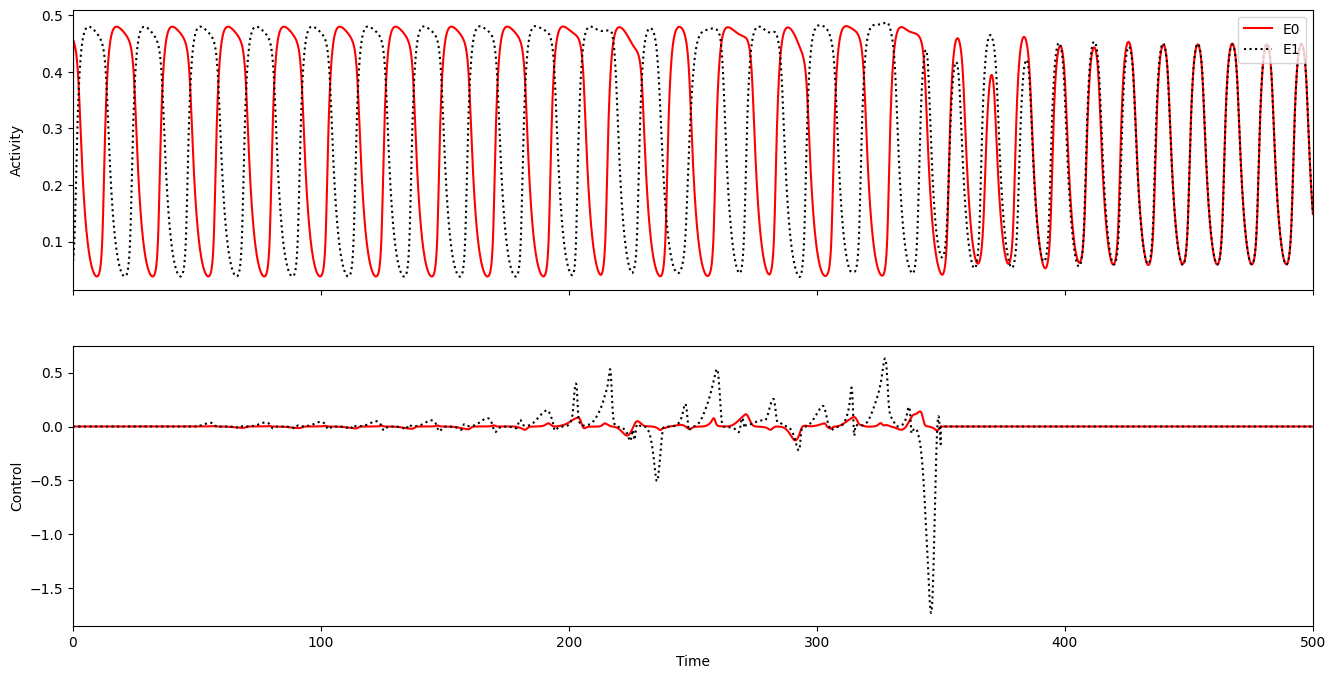

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -3.703324916960309e-05
Final cost : -3.703324916960309e-05
Compute control for a deterministic system
Cost in iteration 0: -0.07406649833920619
Final cost : -0.11655487485910108
Compute control for a deterministic system
Cost in iteration 0: -0.11655487485910108
Final cost : -19.46382264722999


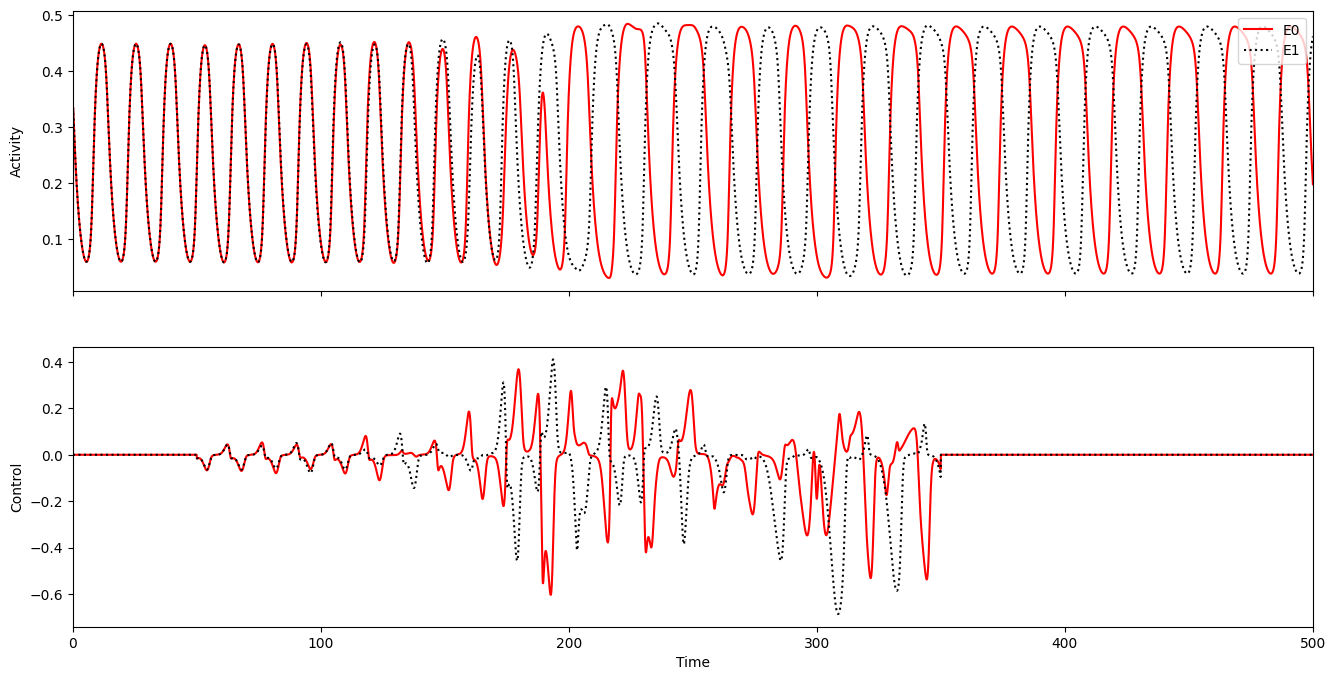

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: 0.2243840682859079
Final cost : 0.2243840682859079
Compute control for a deterministic system
Cost in iteration 0: 224.38406828590757
Final cost : 172.61771870146617
Compute control for a deterministic system
Cost in iteration 0: 172.61771870146617
Final cost : -85.09636164062853


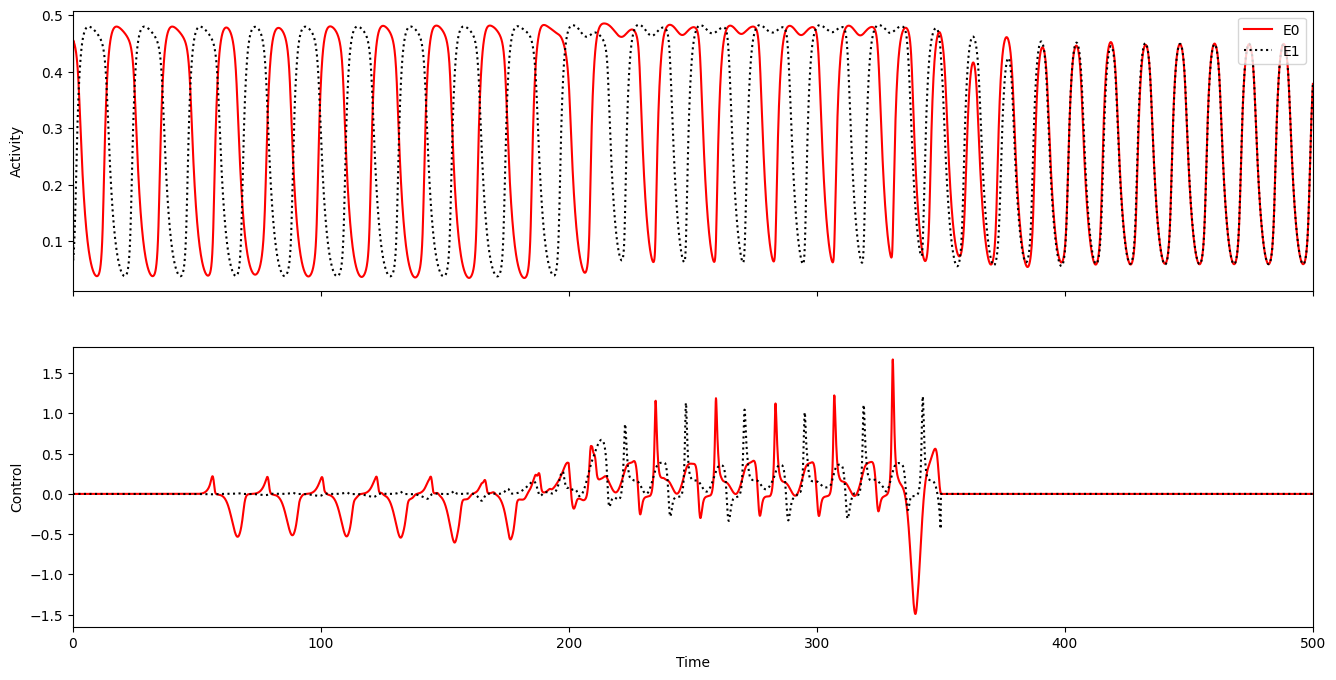

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: 0.2499999999999996
Final cost : 0.2499999999999996
Compute control for a deterministic system
Cost in iteration 0: 500.00000000000017
Final cost : -188.2177894196392
Compute control for a deterministic system
Cost in iteration 0: -188.2177894196392
Final cost : -409.48193776444396


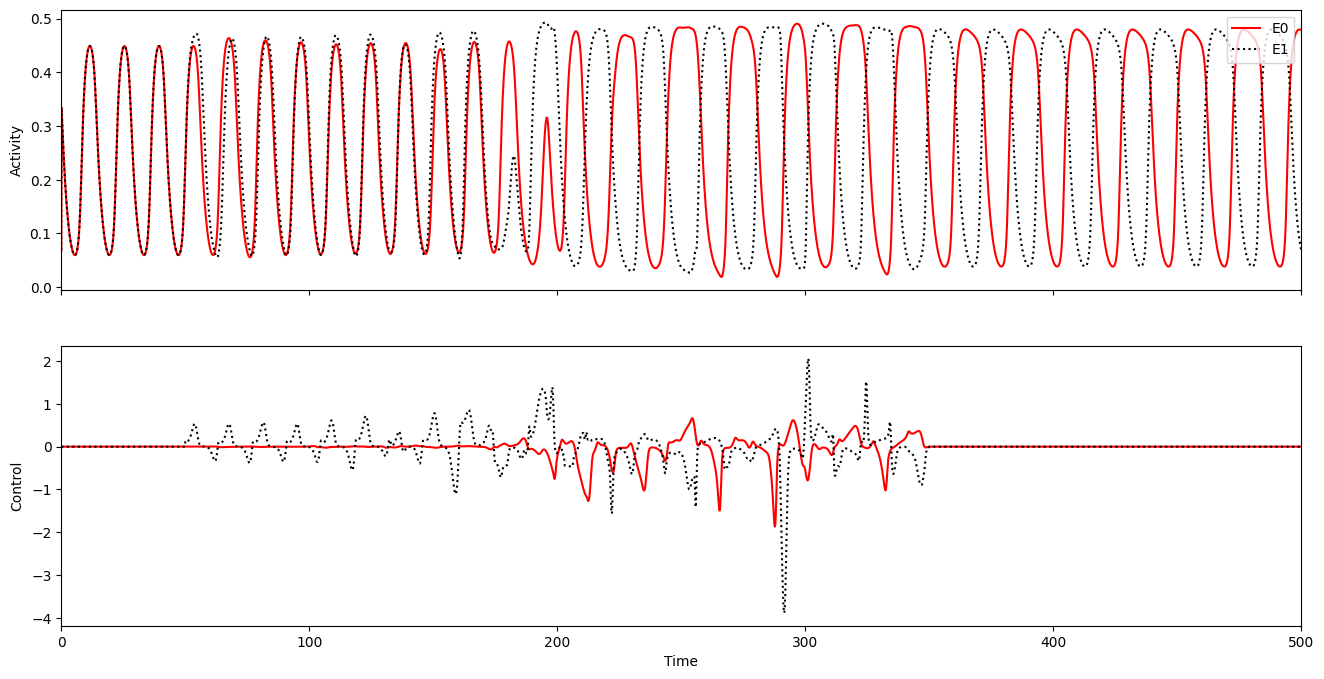

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: 0.029538806847578362
Final cost : 0.029538806847578362
Compute control for a deterministic system
Cost in iteration 0: 886.1642054273515
Final cost : 544.8893193120472


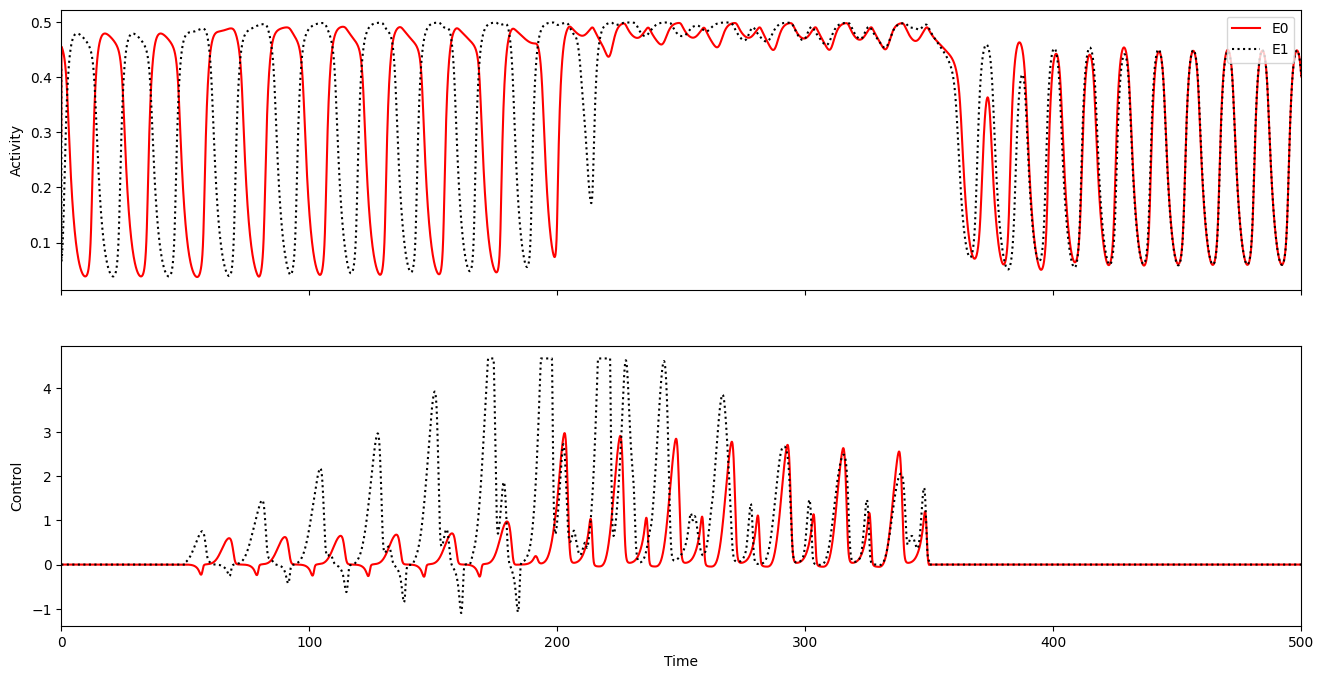

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: 0.036141843312914236
Final cost : 0.036141843312914236
Compute control for a deterministic system
Cost in iteration 0: 0.03400611617690434
Final cost : -6.541449836808047


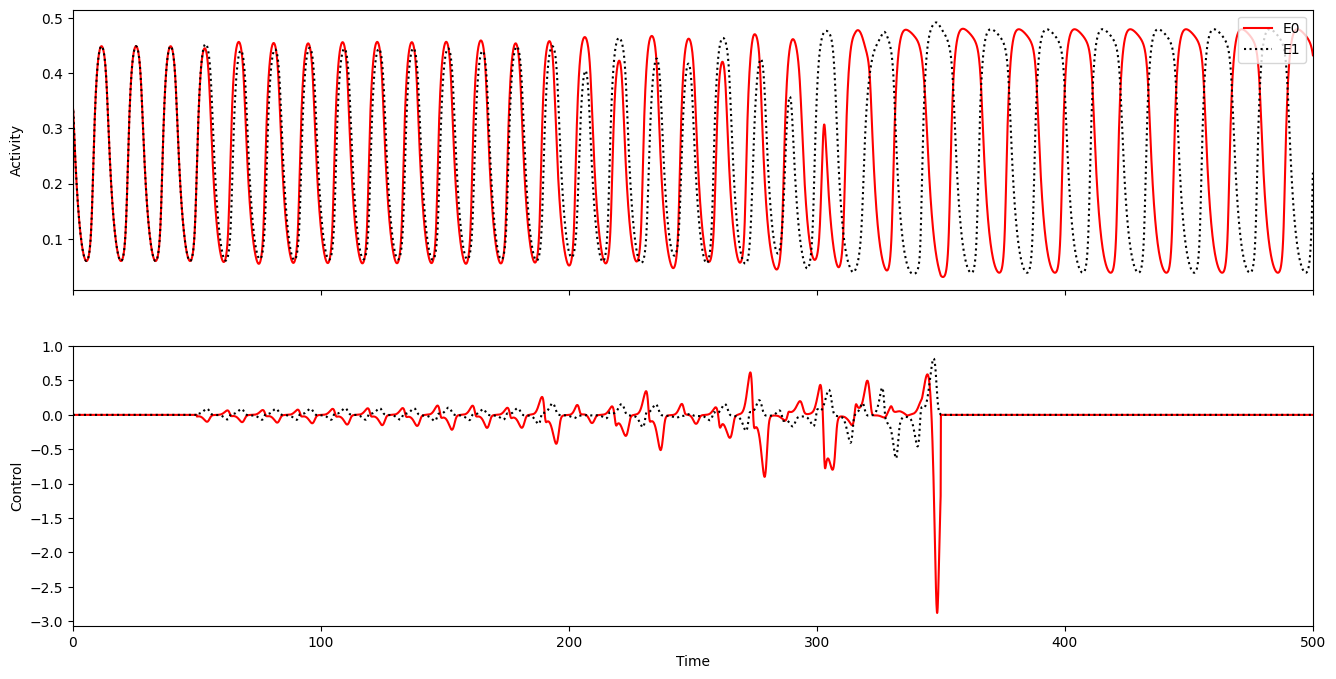

In [36]:
for method in [0,1,2]:  # three cost functionals Fourier, CC, Var
    for i_init in range(2):  # two initial conditions

        model = WCModel(Cmat=cmat, Dmat=delay*20.*cmat)
        model.params["exc_ext_baseline"] =  data["coordinates"][0]
        model.params["inh_ext_baseline"] =  data["coordinates"][1]
        model.params.K_gl = coupling
            
        model.params.duration = duration
        model.params["exc_init"] = data["init_state"][i_init][0]
        model.params["inh_init"] = data["init_state"][i_init][1]
        model.run()

        model_controlled = oc_wc.OcWc(model, data["target_period"][i_init], print_array=pr, cost_interval=(int2,None), control_interval=(int0, int1), 
                                    cost_matrix=costmat, control_matrix=controlmat)
        model_controlled.maximum_control_strength = max_cntrl
        
        model_controlled.weights["w_p"] = 0.
        model_controlled.weights["w_2"] = 1.

        set_standard_weight(model_controlled, method, i_init)
        ucc = model_controlled.compute_total_cost()d
        model_controlled.channelwise_optimization = True
        
        if method == 2 and i_init ==1:
            c_in = np.zeros((model_controlled.control.shape))
            for t in range(int0+1, int1, 1):
                c_in[0,0,t] = c_in[0,0,t-1] + 0.001 * (np.random.rand(1)-0.5)
                c_in[1,0,t] = c_in[1,0,t-1] + 0.001 * (np.random.rand(1)-0.5)

            model_controlled.control = c_in
            model_controlled.update_input()

        model_controlled.optimize(0)
        set_weight(model_controlled, method, i_init, data["weight"])
        model_controlled.grad_method = 0
        
        for k in data["init_range"][method][i_init]:
            model_controlled.zero_step_encountered = False
            model_controlled.step = 10**int(k)
            model_controlled.optimize(4)

        coc = cost_functions.control_strength_cost(model_controlled.control.copy(), weights, dt)

        data["control"][method][i_init] = model_controlled.control.copy()
        data["state"][method][i_init] = model_controlled.get_xs()
    
        plot_control(model_controlled.get_xs(), model_controlled.control.copy(), duration, dt)

In [ ]:
# rerun until convergence

for method in [0,1,2]:  # three cost functionals Fourier, CC, Var
    for i_init in range(2):  # two initial conditions

        if method == 0: continue

        if method == 2 and i_init == 1: continue

        model = WCModel(Cmat=cmat, Dmat=delay*20.*cmat)
        model.params["exc_ext_baseline"] =  data["coordinates"][0]
        model.params["inh_ext_baseline"] =  data["coordinates"][1]
        model.params.K_gl = coupling
            
        model.params.duration = duration
        model.params["exc_init"] = data["init_state"][i_init][0]
        model.params["inh_init"] = data["init_state"][i_init][1]
        model.run()

        model_controlled = oc_wc.OcWc(model, data["target_period"][i_init], print_array=pr, cost_interval=(int2,None), control_interval=(int0, int1), 
                                    cost_matrix=costmat, control_matrix=controlmat)
        model_controlled.maximum_control_strength = max_cntrl
        
        model_controlled.weights["w_p"] = 0.
        model_controlled.weights["w_2"] = 1.

        set_standard_weight(model_controlled, method, i_init)
        ucc = model_controlled.compute_total_cost()
        set_weight(model_controlled, method, i_init, data["weight"])

        model_controlled.control = data["control"][method][i_init].copy()
        model_controlled.update_input()
        model_controlled.simulate_forward()
        model_controlled.channelwise_optimization = True

        for j in range(200):

            coc = cost_functions.control_strength_cost(model_controlled.control.copy(), weights, dt)
            F = model_controlled.compute_total_cost()
            fsync = (F - coc)/data["weight"][method][i_init]
            data["weight"][method][i_init] = coc/ (ucc*(1-1e-6) - fsync)
            if method == 1 and i_init == 1:
                data["weight"][method][i_init] = -0.5*coc/ (ucc*(1-1e-6) - fsync)
            elif method == 2 and i_init == 1:
                data["weight"][method][i_init] = -(1. + 1e-6) * coc/ fsync
                
            set_weight(model_controlled, method, i_init, data["weight"])
            model_controlled.optimize(0)
            
            model_controlled.grad_method = 0
            for k in np.arange(-4, 4., 1.):
                model_controlled.zero_step_encountered = False
                model_controlled.step = 10**(k)
                model_controlled.optimize(20)

            model_controlled.grad_method = 1
            for k in np.arange(-4, 4., 1.):
                model_controlled.zero_step_encountered = False
                model_controlled.step = 10**(k)
                model_controlled.optimize(10)

            coc = cost_functions.control_strength_cost(model_controlled.control.copy(), weights, dt)

            if coc > 0.1:
                data["control"][method][i_init] = model_controlled.control.copy()
                data["state"][method][i_init] = model_controlled.get_xs()
                data["energy_input"][method][i_init] = cost_functions.control_strength_cost(model_controlled.control.copy(), weights, dt)
                print("cost of control = ", data["energy_input"][method][i_init])
        
        plot_control(model_controlled.get_xs(), model_controlled.control.copy(), duration, dt)

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: 0.19949856963336177
Final cost : 0.19949856963336177
Compute control for a deterministic system
Cost in iteration 0: 0.19949856963336177
Cost in iteration 10: 0.19949856959462625
Cost in iteration 20: 0.19949856936855903
Final cost : 0.19949856936855903
Compute control for a deterministic system
Cost in iteration 0: 0.19949856936855903
Converged in iteration 1 with cost 0.19949856936855903
Final cost : 0.19949856936855903
Compute control for a deterministic system
Cost in iteration 0: 0.19949856936855903
Converged in iteration 1 with cost 0.19949856936855903
Final cost : 0.19949856936855903
Compute control for a deterministic system
Cost in iteration 0: 0.19949856936855903
Converged in iteration 1 with cost 0.19949856936855903
Final cost : 0.19949856936855903
Compute control for a deterministic system
Cost in iteration 0: 0.19949856936855903
Converged in iteration 1 with cost 

In [110]:
with open(os.path.join(datadir, '3_2_2.pickle'), 'wb') as f:
    pickle.dump(data, f)

In [79]:
# shapes are the same, but locations might be different - use most efficient as initialization
data["control"][][0] = data["control"][][0].copy()
data["control"][][0] = data["control"][][0].copy()

data["control"][][1] = data["control"][][1].copy()
data["control"][][1] = data["control"][][1].copy()

In [99]:
# maybe shift some signals back or forth in time to test if more efficient
shift_index = int(1. * data["target_period"][abs(int(i_init-1))]/dt)
m, i = 0,0
data["control"][m][i][:,0,:-shift_index] = data["control"][m][i][:,0,shift_index:]  # shift back
#data["control"][m][i][:,0,:-shift_index] = data["control"][m][i][:,0,shift_index:]  # shift forwards

In [132]:
data["energy_input"]

array([[0.39713647, 0.12756237],
       [0.31014756, 0.1184664 ],
       [0.30948269, 0.11870859]])

In [134]:
data["energy_input"]

array([[0.39713647, 0.12756237],
       [0.31002072, 0.1184664 ],
       [0.30909587, 0.11870859]])